## Subject-Verb-Objects

In this notebook, we conduct a series of experiments in order, first, toisolate the subject-verb-object (SVO) triples in the texts of speakers we have gendered male or female, then to explore the *character spaces* they establish for gendered entities within their speech as well as the nature of the *character space* they create for themselves as speakers. 

**Note**: We are not excluding parentheticals in this notebook.

**Next Steps**: Work on code to compile / visualize this as a network graph (?).

## Load Libraries & Data

In [1]:
# IMPORTS
import re, spacy, textacy
import pandas as pd
from nltk import sent_tokenize

# Loading the Data in a gendered partitioned fashion: 
talks_m = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_f = pd.read_csv('talks_female.csv', index_col='Talk_ID')
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')
talks_all = pd.concat([talks_m, talks_f, talks_nog])

# And then grabbing on the texts of the talks:
texts_all = talks_all.text.tolist()
texts_women = talks_f.text.tolist()
texts_men = talks_m.text.tolist()

print(f"From our {talks_all.shape[0]}x{talks_all.shape[1]} CSV, \
we have a list of {len(texts_all)} talks: {len(texts_women)} by women and \
{len(texts_men)} by men.")

From our 992x14 CSV, we have a list of 992 talks: 260 by women and 720 by men.


Lowercasing everything upfront because we don't care whether it is *She* or *she*. 

In [2]:
# Lowercase everything before we create spaCy doc and Textacy SVO triple
texts_w = [text.lower() for text in texts_women]
texts_m = [text.lower() for text in texts_men]

spaCy has three different English language models: small, medium, and large. We use the large model here because our corpus is small and the syntax may be a bit more involved. 

`TO DO`: determine the difference between the models. 

After determining telling spaCy which model to use, we then use its conventions for feeding a set of texts as a list of strings, to it. 

The preview simply checks that everything went as planned: it gives us a word count and the first 50 characters -- which is weird because in theory it has converted the string to a series of spacy objects. 

In [3]:
# Load the Space pipeline to be used
nlp = spacy.load('en_core_web_lg')

# Use the pipe method to feed documents 
docs_w = list(nlp.pipe(texts_w))
docs_m = list(nlp.pipe(texts_m))

# A quick check of our work:
docs_m[0]._.preview

'Doc(2690 tokens: "  thank you so much, chris. and it\'s truly a gr...")'

## Gendered SVOs Dataframes

We now have two sets of spaCy documents, one for the women speakers and one for the men speakers -- there is a third set, composed of groups of speakes, but we are leaving them aside for now. 

In order to examine how each set of texts imagines the agency and actions of gendered persons in their speech, we are going to go through all the clauses in each talk, identify those clauses that have a pronoun as a subject. We are going to compile all the clauses that feature all the subject case pronouns: *first person* (I and we), *second person* (you), and *third person* (she, he, they, it).

`TO DO`: Identify the clauses where gendered entities are acted upon: her, him, me, us, them. (Convert the **spaCy object** in the function below to strings so that we can then match for the objective pronouns?) This may or may not be possibly best done as a separate section.

In the next two cells we create the list of pronouns for whom we seek SVO triples and then we have the function that will grab SVOs starting with those pronouncs and append them to a list each item of which is a dictionary. Each dictionary consists of three entries: one for the subject, one for the verb, and one for the object. This structure was chosen because it makes it easier to instantiate a pandas dataframe in the work that follows.

In [4]:
# Create the lists of gendered pronouns
pronouns = ['i', 'we', 'she', 'he', 'they', 'it', 'you']

In [5]:
# Define the function which will get the SVOs
def actions(terms, doc, svo_list):
    svotriples = list(textacy.extract.triples.subject_verb_object_triples(doc))
    for term in terms:
        for item in svotriples:
            if str(item[0][-1]) == term:
                svo_list.append(
                    {
                        'subject': str(item[0][-1]), 
                        'verb': str(item[1][-1]), 
                        'object': str(item[2])
                    }
                )

With the two lists of dictionaries, one each for talks we have gendered as female and male based on the speaker, we create two dataframes each with three columns.

In [6]:
# Create the two lists
svos_m = []
svos_w = []

# Populate the lists with SVO triples
for doc in docs_m:
    actions(pronouns, doc, svos_m)

for doc in docs_w:
    actions(pronouns, doc, svos_w)

# Convert the lists to dataframes
df_w = pd.DataFrame(svos_w)
df_m = pd.DataFrame(svos_m)

print(df_m.shape, df_w.shape)

(56781, 3) (18602, 3)


The first thing we want to do is simply survey the pronouns: make sure they are present and then to count the number of verbs associated with each one. The total here should match the total length of the dataframe, 18,602. 

In [9]:
# pf = pronoun frequency

# Count the rows with each pronoun as the subject:
procount_m = df_m.groupby(["subject"]).count()
procount_w = df_w.groupby(["subject"]).count()

# Drop the OBJECT column
procount_w.drop('object', axis=1, inplace=True)
# Create PERCENTAGE column
procount_w['percentage'] = procount_w['verb'] /  procount_w['verb'].sum()

# Repeat above for men speakers
procount_m.drop('object', axis=1, inplace=True)
procount_m['percentage'] = procount_m['verb'] /  procount_m['verb'].sum()

# Merge the two dataframes
pf_compare = procount_w.merge(procount_m, 
                        left_on='subject', 
                        right_on='subject',
                        suffixes=('_w', '_m'))

# See the results
pf_compare

,verb_w,percentage_w,verb_m,percentage_m
subject,,,,
he,739,0.039727,2529,0.044540
i,6220,0.334373,15502,0.273014
it,1342,0.072143,4646,0.081823
she,636,0.034190,842,0.014829
they,1919,0.103161,5780,0.101795
we,4645,0.249704,15517,0.273278
you,3101,0.166703,11965,0.210722


<div class="alert alert-block alert-warning"> The code below works, but it uses raw counts and it probably needs to be a percentage so that one can compare the mens' and womens' subcorpora. </div>

Apologies for the awkward line wraps: the pandas code got long.

In [14]:
# Grab the top 20 verbs for each pronoun
pv_w = df_w.groupby(["subject", "verb"])\
.size()\
.groupby(level=0).nlargest(20)\
.reset_index(level=0, drop=True)\
.reset_index(name='Count')

# Save to CSV for easier viewing
# pv_w.to_csv('../output/pv_w.csv')

# Repeat for the men
pv_m = df_m.groupby(["subject", "verb"])\
.size()\
.groupby(level=0).nlargest(20)\
.reset_index(level=0, drop=True)\
.reset_index(name='Count')
# pv_m.to_csv('../output/pv_m.csv')

In [15]:
df_w.groupby("subject").groups

{'he': [48, 49, 141, 142, 143, 144, 145, 146, 147, 148, 305, 306, 391, 433, 493, 494, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 866, 974, 975, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1466, 1467, 1468, 1469, 1470, 1571, 1572, 1573, 1574, 1575, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1736, 1737, 1738, 1739, 1878, 1879, 1880, 1881, 1927, 2119, 2296, 2297, 2365, 2366, 2367, 2368, 2369, 2492, 2493, 2494, 2495, 2496, 2497, 2733, 2734, 2735, 2736, 2737, 2738, ...], 'i': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136

In [16]:
df_w.groupby("subject").get_group('he')

,subject,verb,object
48,he,does,"[which, time]"
49,he,married,[mom]
141,he,led,[them]
142,he,stopped,[nephites]
143,he,visited,[nephites]
...,...,...,...
18244,he,having,[conversation]
18245,he,doing,[it]
18246,he,goes,[you]
18247,he,turns,[you]


In [ ]:
# This gives you a dataframe with just the index
# and the verb
df2 = df_w.groupby(['subject'])[['verb']] 

In [ ]:
df3 = df_w.groupby(['subject', 'verb'])\
.size()\
.groupby(level=0).nlargest(5)\
.reset_index(level=0, drop=True)\
.reset_index(name='Count')

In [ ]:
df3.head()

## All SVOs to Dataframe

Since we create SVOs for every sentence in the two subcorpora, why not save both to two dataframes?

In [5]:
def actions(doc, svo_list):
    svotriples = list(textacy.extract.triples.subject_verb_object_triples(doc))
    for item in svotriples:
        svo_list.append(
            {
                'subject': str(item[0][-1]), 
                'verb': str(item[1][-1]), 
                'object': str(item[2])
            }
        )

In [7]:
# Create the two lists
all_svos_m = []
all_svos_w = []

# Populate the lists with SVO triples
for doc in docs_m:
    actions(doc, all_svos_m)

for doc in docs_w:
    actions(doc, all_svos_w)

# Convert the lists to dataframes
df_all_svos_w = pd.DataFrame(all_svos_w)
df_all_svos_m = pd.DataFrame(all_svos_m)

print(df_all_svos_m.shape, df_all_svos_w.shape)

(80331, 3) (26527, 3)


Interesting. If the counts above are accurate, that there are 80,331 SVOs in total in the male speaker subcorpora and 56,781 begin with on of the pronouns listed above and 26,527 total SVOs for the female speaker subcorpus with 18,602 beginning with pronouns, then the preponderance of sentences in TED talks begin with a rather small set of pronouns:

```
56,781 / 80,331 = .706
18,602 / 26,527 = .701
```
Is that possible? Or is there some flaw in the SVO code base or in my code?

## Resolving the Number of Sentences

The code above suggests that 70% of the SVOs in TED talks have `'i', 'we', 'she', 'he', 'they', 'it', 'you'` as their subject. It's not clear, however, how much the SVO pattern represents all sentences in the talks. In this section we explore counting sentences, both through NLTK and spaCy, but also a hand count of a few sample texts to see how well our code is reflecting underlying realities.

### NLTK

In [51]:
sents_w = [ sent_tokenize(text) for text in texts_w ]    
sents_m = [ sent_tokenize(text) for text in texts_m ]

print(len(sents_w[0]))

187


In [53]:
sent_count_w = 0
sent_per_talk = []

for in_text in sents_w:
    num_sents = len(in_text)
    sent_count_w += num_sents
    sent_per_talk.append(num_sents)
    
print(sent_count)

30799


In [54]:
sent_count_m = 0
for text in texts_m:
    sent_count_m += len(sent_tokenize(text))
print(sent_count_m)

96342


In [67]:
sent_count_w = 0
for text in texts_w:
    sent_count_w += len(sent_tokenize(text))
print(sent_count_w)

30799


The two blocks of code give us NLTK's answer to total number of sentences for all the talks, which is larger than the total number of SVOs:

```
26,527 SVOs in 30,799 sentences in female speaker subcorpus
80,331 SVOs in 96,342 sentences in male speaker subcorpus
```
That makes for the following percentages of pronoun SVOs out of the total number of sentences:

In [56]:
print(f"{18602 / 30799}")
print(f"{56781 / 96342}")

0.6039806487223611
0.5893691225010899


### Some Further Experiments with the NLTK Counts

In [42]:
avg_w = sent_count/len(sents_w)

In [48]:
sent_per_talk.sort()

In [49]:
sent_per_talk

[1,
 7,
 7,
 10,
 12,
 15,
 18,
 18,
 22,
 24,
 26,
 26,
 26,
 28,
 28,
 28,
 30,
 31,
 31,
 32,
 33,
 33,
 33,
 34,
 34,
 34,
 35,
 36,
 38,
 39,
 39,
 40,
 40,
 42,
 42,
 43,
 43,
 45,
 45,
 45,
 46,
 46,
 47,
 48,
 50,
 50,
 50,
 51,
 53,
 55,
 55,
 55,
 56,
 56,
 58,
 59,
 60,
 62,
 62,
 62,
 62,
 63,
 63,
 65,
 68,
 69,
 69,
 70,
 71,
 71,
 72,
 72,
 73,
 73,
 74,
 75,
 76,
 77,
 78,
 78,
 79,
 79,
 79,
 80,
 80,
 82,
 82,
 83,
 83,
 84,
 85,
 85,
 85,
 86,
 87,
 87,
 87,
 90,
 90,
 91,
 92,
 94,
 94,
 95,
 95,
 96,
 96,
 96,
 96,
 96,
 97,
 97,
 99,
 100,
 101,
 102,
 103,
 103,
 103,
 104,
 105,
 105,
 105,
 106,
 107,
 108,
 110,
 110,
 112,
 115,
 117,
 118,
 118,
 119,
 120,
 121,
 122,
 122,
 122,
 123,
 124,
 125,
 126,
 127,
 127,
 128,
 129,
 129,
 129,
 130,
 130,
 130,
 130,
 131,
 132,
 132,
 132,
 133,
 135,
 137,
 137,
 138,
 138,
 138,
 139,
 141,
 141,
 141,
 143,
 143,
 144,
 144,
 146,
 147,
 148,
 149,
 150,
 150,
 151,
 151,
 151,
 152,
 153,
 154,
 154,
 154,


In [50]:
from matplotlib import pyplot as plt

(array([27., 41., 55., 42., 41., 30., 14.,  9.,  0.,  1.]),
 array([  1. ,  35.7,  70.4, 105.1, 139.8, 174.5, 209.2, 243.9, 278.6,
        313.3, 348. ]),
 <BarContainer object of 10 artists>)

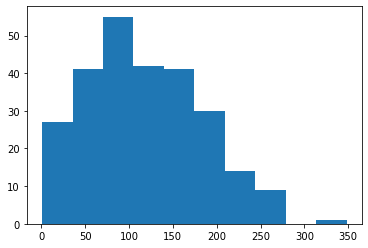

In [41]:
plt.hist(sent_per_talk)

### spaCy

In [63]:
# If you append [0:10] to sent in the print statement
# it gives you just the first part of a sentence:
# useful for scanning for subjects

for sent in docs_w[0].sents:
    print(sent[0:10])

  if you're here today — and i'm
however, when we're not at ted, we
and that's because most people with decision-making
   the reason why i'm here today, in
she turned out to be a much bigger dog than
when she came into my life, we were fighting
the area also has one of the lowest ratios of
   so when i was contacted by the parks department
i'd lived in this area all my life,
then, while jogging with my dog one morning,
there were weeds and piles of garbage and other stuff
i knew that this forgotten little street-end,
and i knew it would grow to become the proud
we garnered much support along the way, and the
we leveraged that $10,000 seed grant more than 300
   and in the fall, i'm going to
   (audience whistles)
   thank you very much.
   (applause)    that's him pressing my
   (laughter)    (applause)    but
we feel the problems right now, and have for
environmental justice, for those of you who may not
   unfortunately, race and class are extremely reliable indicators
as a black pe

In [66]:
print(len(list(docs_w[0].sents)))

191


In [68]:
snt_cnt_w = 0
for doc in docs_w:
    snt_cnt_w += len(list(doc.sents))
print(snt_cnt_w)

31673


In [69]:
snt_cnt_m = 0
for doc in docs_m:
    snt_cnt_m += len(list(doc.sents))
print(snt_cnt_m)

99039


The total sentence counts are:
```
Women - NLTK : 30,799
        spaCy: 31,673
Men -   NLTK : 96,342
        spaCy: 99,039
```